In [2]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

In [3]:
from gensim.models import KeyedVectors
model_dir = 'wiki-news-300d-1M.vec'
model = KeyedVectors.load_word2vec_format(model_dir, binary=False)

In [166]:
inputfile="230707_3.csv"

In [167]:
data=pd.read_csv(f"{inputfile}")

interaction_array=np.array(data['interactions'])
interaction_with_array=np.array(data['target_obj'])
action_array=np.array(data['action'])

In [168]:
data

,time,x,y,action,interactions,target_obj
0,2023-07-07 15:49:26.734146,79,171,walking,none,none
1,2023-07-07 15:49:26.939803,86,158,walking,none,none
2,2023-07-07 15:49:27.144140,100,144,walking,none,none
3,2023-07-07 15:49:27.349216,107,131,walking,none,none
4,2023-07-07 15:49:27.553345,121,111,walking,none,none
...,...,...,...,...,...,...
1377,2023-07-07 15:54:32.917255,95,322,sitting,none,none
1378,2023-07-07 15:54:33.146505,106,298,sitting,none,none
1379,2023-07-07 15:54:33.365348,84,308,sitting,none,none
1380,2023-07-07 15:54:33.606363,100,305,sitting,none,none


In [169]:
data = data[(data['action'] != 'walking') | (data['interactions'] != 'none')]

In [170]:
data[data['action'] == 'laying']

,time,x,y,action,interactions,target_obj
1305,2023-07-07 15:54:16.799784,139,357,laying,none,none
1371,2023-07-07 15:54:31.562054,105,329,laying,none,none
1372,2023-07-07 15:54:31.793765,107,327,laying,none,none
1373,2023-07-07 15:54:32.016229,111,320,laying,none,none


In [171]:
data2=data.loc[:,['x','y']]

In [172]:
data2

,x,y
9,120,98
12,108,111
13,113,109
14,119,104
16,132,104
...,...,...
1377,95,322
1378,106,298
1379,84,308
1380,100,305


In [173]:
data3 = [list(e) for e in zip(data['x'],data['y'])]

In [174]:
data3

[[120, 98],
 [108, 111],
 [113, 109],
 [119, 104],
 [132, 104],
 [139, 98],
 [133, 101],
 [142, 99],
 [169, 134],
 [174, 141],
 [181, 145],
 [176, 146],
 [171, 146],
 [163, 144],
 [141, 146],
 [143, 140],
 [146, 140],
 [151, 138],
 [154, 138],
 [165, 127],
 [162, 132],
 [165, 129],
 [160, 135],
 [157, 138],
 [155, 134],
 [153, 138],
 [150, 139],
 [148, 142],
 [153, 136],
 [154, 135],
 [153, 134],
 [155, 136],
 [151, 141],
 [155, 133],
 [152, 133],
 [154, 133],
 [150, 136],
 [152, 134],
 [147, 139],
 [152, 134],
 [151, 134],
 [151, 134],
 [150, 133],
 [150, 138],
 [151, 135],
 [152, 135],
 [149, 136],
 [150, 136],
 [155, 129],
 [159, 126],
 [157, 127],
 [159, 127],
 [153, 136],
 [152, 137],
 [152, 141],
 [157, 135],
 [151, 139],
 [153, 135],
 [153, 135],
 [159, 129],
 [152, 136],
 [153, 135],
 [153, 133],
 [155, 132],
 [158, 128],
 [160, 127],
 [155, 133],
 [157, 132],
 [152, 137],
 [157, 132],
 [151, 138],
 [157, 131],
 [153, 134],
 [152, 137],
 [148, 138],
 [151, 137],
 [152, 135],
 [

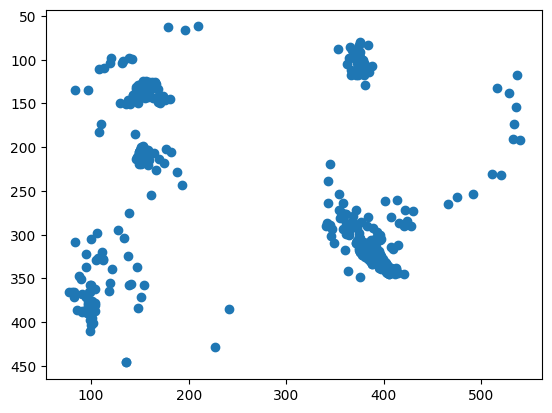

In [175]:
# data=pd.read_csv("20230623.csv")
plt.gca().invert_yaxis()  # y軸を反転する
plt.scatter(data.loc[:, ['x']], data.loc[:, ['y']])

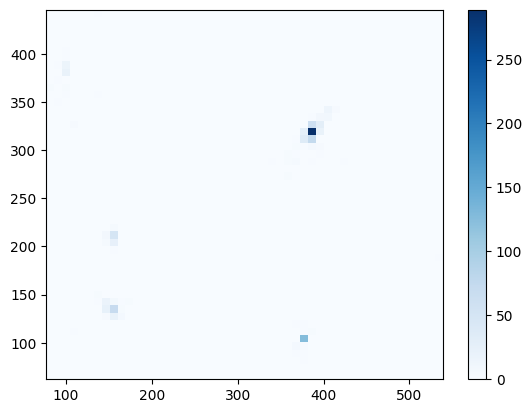

In [176]:
# data=pd.read_csv("20230623.csv")
plt.hist2d(data['x'], data['y'], bins=50, cmap='Blues')
plt.colorbar()
plt.show()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0eb1675af0>
Traceback (most recent call last):
  File "/home/ozaki/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/ozaki/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/ozaki/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/ozaki/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_m

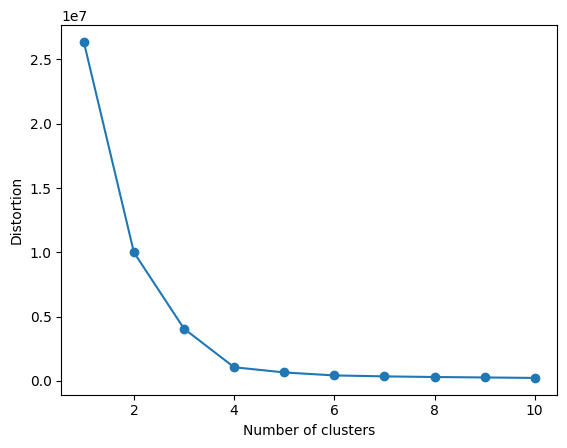

In [177]:
#elbow
distortions = []

for i in range(1,11):                 
    km = KMeans(n_clusters=i,
                init='k-means++',     
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(data3)                        
    distortions.append(km.inertia_)   

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [178]:
N=4

In [179]:
km = KMeans(n_clusters=N, random_state=42)
label = km.fit_predict(data2[:])

In [180]:
label

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

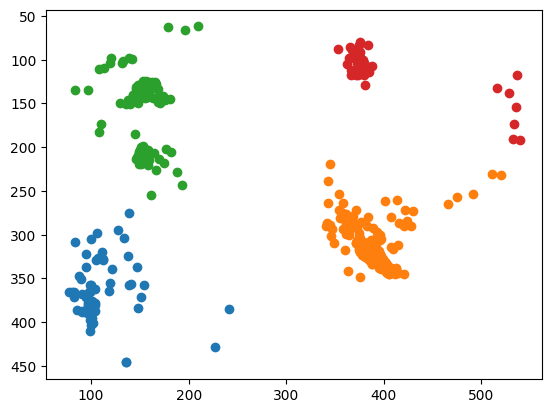

In [181]:
plt.gca().invert_yaxis()  # y軸を反転する
for i in range(N):
    plt.scatter(data.loc[:, ['x']][label==i], data.loc[:, ['y']][label==i])
# plt.scatter(data.loc[:, ['z']][label==0], data.loc[:, ['x']][label==0])
# plt.scatter(data.loc[:, ['z']][label==1], data.loc[:, ['x']][label==1])
# plt.scatter(data.loc[:, ['z']][label==2], data.loc[:, ['x']][label==2])
# plt.scatter(data.loc[:, ['z']][label==3], data.loc[:, ['x']][label==3])
plt.show()

In [182]:
dd1=data.loc[:, ['y']][label==0]
ddList1 = dd1["y"].index.to_list()
dd2=data.loc[:, ['y']][label==1]
ddList2 = dd2["y"].index.to_list()
dd3=data.loc[:, ['y']][label==2]
ddList3 = dd3["y"].index.to_list()
dd4=data.loc[:, ['y']][label==3]
ddList4 = dd4["y"].index.to_list()

In [183]:
ddList3

[9,
 12,
 13,
 14,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 191,
 203,
 207,
 217,
 218,
 219,
 1

[0.5221065, 0.38132125, 0.3727542, 0.5533186]
[0.56912994, 0.33438444, 0.35411963, 0.3125045]
[0.47191072, 0.36996427, 0.41680357, 0.45024875]
[0.5221065, 0.38132125, 0.3727542, 0.5533186]


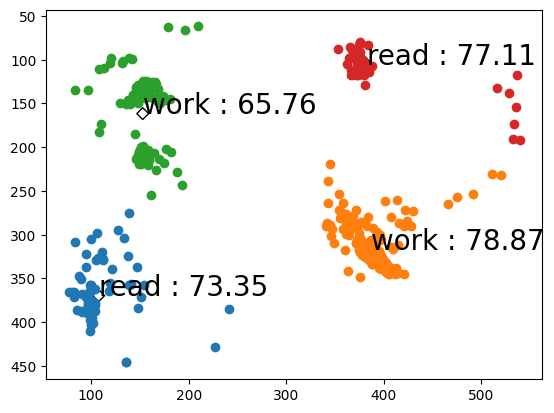

In [184]:
dd1=data.loc[:, ['y']][label==0]
ddList1 = dd1["y"].index.to_list()
dd2=data.loc[:, ['y']][label==1]
ddList2 = dd2["y"].index.to_list()
dd3=data.loc[:, ['y']][label==2]
ddList3 = dd3["y"].index.to_list()
dd4=data.loc[:, ['y']][label==3]
ddList4 = dd4["y"].index.to_list()

observedList1 =[]
for i in ddList1:
    if(interaction_array[i]!="none"):
        observedList1.append(interaction_array[i])
        if(action_array[i]=="laying"):
            observedList1.append(action_array[i])
        observedList1.append(interaction_with_array[i])

observedList2 =[]
for i in ddList2:
    if(action_array[i]=="laying"):
            observedList2.append(action_array[i])
    if(interaction_array[i]!="none"): 
        observedList2.append(interaction_array[i])
        observedList2.append(interaction_with_array[i]) 

observedList3 =[]
for i in ddList3:
    if(action_array[i]=="laying"):
            observedList3.append(action_array[i])
    if(interaction_array[i]!="none"):
        observedList3.append(interaction_array[i])
        observedList3.append(interaction_with_array[i])

observedList4 =[]
for i in ddList4:
    if(action_array[i]=="laying"):
            observedList4.append(action_array[i])
    if(interaction_array[i]!="none"):
        observedList4.append(interaction_array[i])
        observedList4.append(interaction_with_array[i])

split_values = []
original_values = []
for item in observedList1:
    split_items = item.split(',')
    split_values.extend(split_items)
    original_values.extend([item] * len(split_items))

split_values2 = []
original_values2 = []
for item in observedList2:
    split_items = item.split(',')
    split_values2.extend(split_items)
    original_values2.extend([item] * len(split_items))

split_values3 = []
original_values3 = []
for item in observedList3:
    split_items = item.split(',')
    split_values3.extend(split_items)
    original_values3.extend([item] * len(split_items))

split_values4 = []
original_values4 = []
for item in observedList4:
    split_items = item.split(',')
    split_values4.extend(split_items)
    original_values4.extend([item] * len(split_items))

centers = km.cluster_centers_
plt.gca().invert_yaxis()  # y軸を反転する
plt.scatter(centers[:, 0], centers[:, 1], marker="D", facecolors='none', edgecolors='black')
observed_lists = [split_values, split_values2, split_values3, split_values4]
utilization_class_list = ['work','rest','dining','read']
utilization = 'none'

for i, observed_list in enumerate(observed_lists):
    score = [np.mean([model.similarity(utilization, observe) for observe in observed_list]) 
             for utilization in utilization_class_list]
    max_socre = np.max(score)

    similar_list = model.most_similar(f"{utilization}")
    most_similar_score =similar_list[0][1]
    prob = max_socre / most_similar_score *100

    max_index = np.argmax(score)
    print(score)
    utilization = utilization_class_list[max_index]
    plt.scatter(data.loc[:, ['x']][label==i], data.loc[:, ['y']][label==i])
    if prob>50:
        plt.text(centers[i][0], centers[i][1], f"{utilization} : {round(prob, 2)}", fontsize=20)
    else:
        plt.text(centers[i][0], centers[i][1], f"unknown", fontsize=20)


In [145]:
similar_list = model.most_similar('work')
for similar_set in similar_list:
    print(str(similar_set[0])+ " : " + str(similar_set[1]))

works : 0.717581570148468
working : 0.6682043671607971
job : 0.6681519746780396
Work : 0.642331063747406
work. : 0.6332440972328186
research : 0.6295222640037537
work- : 0.6242907047271729
doing : 0.6225779056549072
effort : 0.6146255731582642
work-- : 0.6137425303459167


In [90]:
wordsList = ["keyboard", "cellphone", "bottle", "book", "carpet", "cushion", "food", "sitting", "standing", "walking", "drinking", "reading", "calling", "working", "holding", "laying", "eating"]
for words in wordsList:
    print(f'{words}',model.similarity('work', f'{words}'))

keyboard 0.37852472
cellphone 0.3088381
bottle 0.34577823
book 0.54410374
carpet 0.28675038
cushion 0.25257522
food 0.39777228
sitting 0.37597668
standing 0.41922814
walking 0.39674303
drinking 0.37540823
reading 0.5001093
calling 0.37093756
working 0.6682043
holding 0.32377398
laying 0.38037142
eating 0.36711758


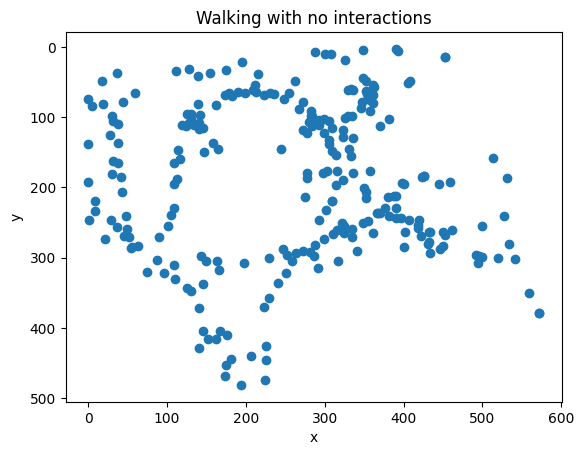

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルを読み込む
df = pd.read_csv(f'{inputfile}')

# 条件に合致する行を抽出する
filtered_df = df[(df['action'] == 'walking') & (df['interactions'] == 'none')]

# x列とy列を取得
x_values = filtered_df['x']
y_values = filtered_df['y']

# プロット
plt.scatter(x_values, y_values)
plt.gca().invert_yaxis()  # y軸を反転する
plt.xlabel('x')
plt.ylabel('y')
plt.title('Walking with no interactions')
plt.show()
